# Geododing of Cracow housing offers, from OtoDom.pl service

downloaded with  tool:

https://ofedoruk.pl/szukamy-mieszkania-za-pomoca-pythona-i-beautiful-soup/,

In [ ]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")
import numpy as np 
import pandas as pd 
import seaborn as sns
import geopandas as gpd
import difflib
from difflib import SequenceMatcher
import matplotlib.pyplot as plt

# read downlaoded offers - csv file

In [ ]:
df = pd.read_csv('csv\offers.csv', header = 0, sep = ";", error_bad_lines=False)
il_ogloszen = df.shape[0]
display('we have {} offers'.format(il_ogloszen))

# Extracting Cracow street names from OpenStreetMap layer

In [ ]:
# pobranie listy ulic z warstwy OpenStreetMap dla Krakowa
streets = gpd.read_file(r'shp\drogi_krk_osm_dis.shp')
lista_nazw = []

for i in streets.itertuples():
    # dodac zakres x y ulicy
    # pobranie bounding box i pozniej losowanie w ramach tego bounding box
    ulica = i.name
    ulica_list = ulica.split(" ")
    lista_nazw.append(ulica_list[-1])

# stworzenie listy dzielnic  
lista_dzielnic = []
for i in df.itertuples():
    dzielnica = i.dzielnica
    if dzielnica not in lista_dzielnic:
            lista_dzielnic.append(dzielnica)
            
lista_dzielnic.append(['Justowska', 'Ruczaj'])

# Functions for extraction of the street names from the offers descriptions

In [ ]:
# szukamy czy w opisie mielismy nazwe ulicy
def szukaj_ulicy(cell):
    opis_list = cell.split(" ")
    for slowo in opis_list:
        if len(slowo) > 4:
            for ulica in lista_nazw:
                ratio = SequenceMatcher(None, slowo, ulica).ratio()
                if ratio > 0.85:
                    return ulica
                
def geokoduj(df, pole, rodzaj):
    df['geo_location'] = df[pole].apply(geocode)
    df['rodzaj'] = rodzaj
    located = df.loc[df["geo_location"].notnull()]
    not_located = df.loc[df["geo_location"].isnull()]
    return(located, not_located)

def czyszczenie(df, ALL_NUMERIC_COLUMNS):
    # numerical data cleaning
    
    df = df.rename(columns={'pokoje': 'no_rooms', 'metraz': 'flat_area',
                             'cena_za_metr': 'price'})
    df[ALL_NUMERIC_COLUMNS]= df[ALL_NUMERIC_COLUMNS].replace(['>',' ', '/', 'pokoje',
                 'pokój', 'pokoi', 'zł', 'm²'],'', regex=True)
    df[ALL_NUMERIC_COLUMNS]= df[ALL_NUMERIC_COLUMNS].replace(',','.', regex=True)
    df[ALL_NUMERIC_COLUMNS] = df[ALL_NUMERIC_COLUMNS].astype(float)
    
    # outliers
    df = df.loc[df['price'] < 25000]
    df = df.loc[df['price'] > 3000]
    df = df.drop_duplicates(ALL_NUMERIC_COLUMNS, keep='first')  #usuwanie duplikatow

    return df

# Data cleaning

In [ ]:
# probe data
df_probe = df.iloc[:500]

ALL_NUMERIC_COLUMNS= ['price', 'flat_area', 'no_rooms']
df_probe = czyszczenie(df_probe, ALL_NUMERIC_COLUMNS)
df_probe['opis'] = df_probe['opis'].replace(["ul.", "-", ",", "os."]," ", regex=True)

# przypisanie ulicy
df_probe['ulica'] = df_probe['opis'].apply(szukaj_ulicy)
df_probe['lokator_ulica_dzielnica'] = "Kraków, " + df_probe['dzielnica'] + ", " + df_probe['ulica']

display(df_probe.head(5))

# Geocoding base on street name

In [6]:
# geocoding
import geopy
import geopandas
from geopy.geocoders import Nominatim

locator = Nominatim(user_agent ='nlp2')
from geopy.extra.rate_limiter import RateLimiter

# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
geokoduj2 = geokoduj(df_probe.loc[df_probe["ulica"].notnull()], 'lokator_ulica_dzielnica', 'dzielnica_ulica')
located = geokoduj2[0]

il_ogloszen = located.shape[0]
display('we have {} geocoded offers out of all {}'.format(il_ogloszen,df_probe.shape[0]))

# 3 - create longitude, laatitude and altitude from location column (returns tuple)
located['point'] = located['geo_location'].apply(lambda loc: tuple(loc.point) if loc else None)

# 4 - split point column into latitude, longitude and altitude columns
located[['latitude', 'longitude', 'altitude']] = pd.DataFrame(located['point'].tolist(), index=located.index)

# 5 - save geolocated output to csv
located.to_csv('geokoding_2020014.csv')

# Moving each offer a bit to avoid overlapping

In [7]:
# przesuniecie o x, y zaby punkty na tej samej ulicy nie byly w tych samych miejscach
located['latitude_odch'] = located.apply(lambda x: np.random.uniform(0, 0.006), axis=1)
located['longtitude_odch'] = located.apply(lambda x: np.random.uniform(0, 0.012), axis=1)
located['latitude'] = located['latitude'] + located['latitude_odch']
located['longitude'] = located['longitude'] + located['longtitude_odch']
located = located.loc[located['latitude'] < 52]

display(located.head(5))

,opis,dzielnica,no_rooms,cena,flat_area,price,link,data,ulica,lokator_ulica_dzielnica,geo_location,rodzaj,point,latitude,longitude,altitude,latitude_odch,longtitude_odch
1,Apartament u stóp Wawelu,: Stare Miasto,2.0,745 000,52.5,14190.0,https://www.otodom.pl/oferta/apartament-u-stop...,2019-03-07 15:26:00.407141,Wawelu,"Kraków, : Stare Miasto, Wawelu",(Bazylika archikatedralna pw. Świętych Stanisł...,dzielnica_ulica,"(50.05465045, 19.9354553914, 0.0)",50.056261,19.938416,0.0,0.001611,0.002961
7,Do remontu w niskiej zabudowie + ogródek!,: Stare Dębniki,2.0,286 000,35.6,8034.0,https://www.otodom.pl/oferta/do-remontu-w-nisk...,2019-03-07 15:26:00.408144,budowie,"Kraków, : Stare Dębniki, budowie","(Cmentarz komunalny w budowie, Dębniki, Kraków...",dzielnica_ulica,"(50.0000448, 19.8424100466, 0.0)",50.005369,19.852240,0.0,0.005324,0.009830
13,Nowe 2 pokojowe 40m2 Głowackiego,: Bronowice Małe,2.0,370 000,40.3,9181.0,https://www.otodom.pl/oferta/nowe-2-pokojowe-4...,2019-03-07 15:26:00.409147,Głowackiego,"Kraków, : Bronowice Małe, Głowackiego","(Wojciecha Bartosza Głowackiego, Bronowice, Kr...",dzielnica_ulica,"(50.0775737, 19.9042255, 0.0)",50.082235,19.915027,0.0,0.004661,0.010801
23,3 pokoje wysoki standard Ugorek,: Ugorek,3.0,429 700,48.7,8823.0,https://www.otodom.pl/oferta/3-pokoje-wysoki-s...,2019-03-07 15:26:00.410149,Ugorek,"Kraków, : Ugorek, Ugorek","(Ugorek, Prądnik Czerwony, Kraków, województwo...",dzielnica_ulica,"(50.0761099, 19.9820437, 0.0)",50.076734,19.992094,0.0,0.000624,0.010050
28,2 pokojowe z Ogródkiem 43m2 Wola Justowska,: Bronowice,2.0,416 000,43.0,9674.0,https://www.otodom.pl/oferta/2-pokojowe-z-ogro...,2019-03-07 15:26:00.410149,Justowska,"Kraków, : Bronowice, Justowska","(Justowska, Osiedle Widok Zarzecze, Bronowice,...",dzielnica_ulica,"(50.0754855, 19.8840381, 0.0)",50.077569,19.887601,0.0,0.002083,0.003563


# Making GeoDataFrame

In [8]:
# DataFrame with x,y to GeoDataFrame
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(
    located, geometry=gpd.points_from_xy(x=located.longitude, y=located.latitude),
    crs={'init':'epsg:4326'})

gdf = gdf.loc[gdf['latitude'] < 50.2]
gdf = gdf.loc[gdf['latitude'] > 49] 
gdf = gdf.loc[gdf['longitude'] <21]

# reprojekcja do Panstwowego Ukladu Wspolrzednych Geodezyjnych PUWG1992
gdf= gdf.to_crs({'init': 'epsg:2180'})
liczba = gdf.shape[0]

# Plotting GeoDataFrame with MatPlotLib

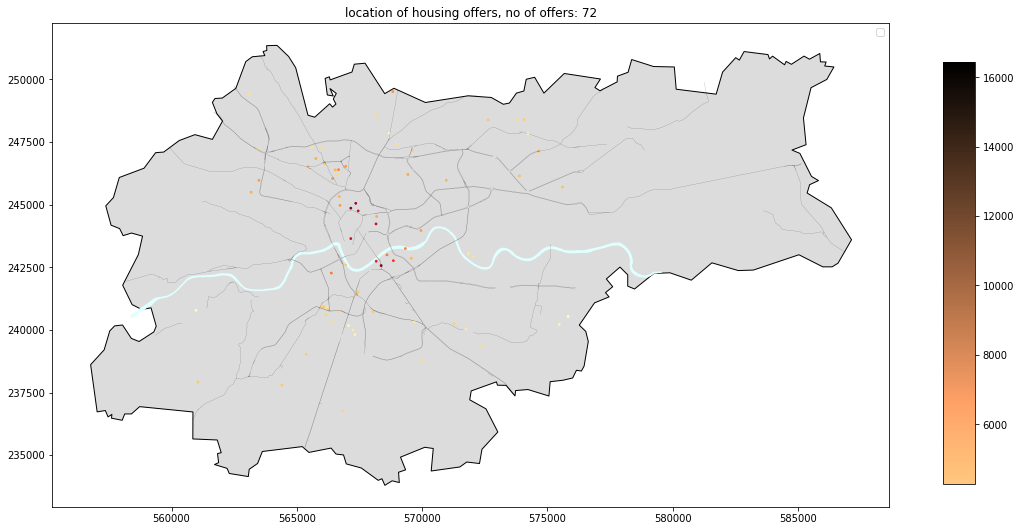

In [9]:
# plot geocoded offers
plt.rcParams['figure.figsize'] = (15, 15)
plt.rcParams['font.family'] = 'sans-serif'

krk_border = gpd.read_file(r'shp\krk_border.shp')
vistula = gpd.read_file(r'c:\Users\marci\git\Cracow_housing\shp\osm_vistula_92.shp')
rds = gpd.read_file(r'c:\Users\marci\git\Cracow_housing\shp\osm_rds_92.shp')

ax = krk_border.plot(color ='gainsboro', edgecolor='black')
ax.set_title("location of housing offers, no of offers: {}".format(liczba))
ax.legend()
vistula.plot(ax=ax, color='lightcyan');
rds.plot(ax=ax, color='black', linewidth = 0.1);
gdf.plot(ax=ax, marker='o',column='price', cmap='YlOrRd', markersize=3);

# colorbar will be created by ...
fig = ax.get_figure()
# add colorbar axes to the figure
# here, need trial-and-error to get [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.95, 0.3, 0.03, 0.39])   
colormap = "copper_r"   # add _r to reverse the colormap
sm = plt.cm.ScalarMappable(cmap=colormap, \
                norm=plt.Normalize(vmin=min(gdf.price), vmax=max(gdf.price)))

# blank-out the array of the scalar mappable 'sm'
sm._A = []
# draw colorbar into 'cbax'
fig.colorbar(sm, cax=cbax, format="%d")

# dont use: plt.tight_layout()
plt.show()

# Plotting GeoDataFrame with Folium - interactive map with pop-ups

In [12]:
#wyswietlenie punktow na mapie, razem z pop ups
import folium

Mmap = folium.Map(location=[50.05, 19.95], zoom_start=12, )

def getColor(rodzaj):
    if rodzaj == 'opis':
        return 'blue'
    elif rodzaj == 'ulica':
        return 'red'
    else:
        return 'blue'

for lat, lon, opis, link, dzielnica, rodzaj, ulica in zip(located['latitude'], located['longitude'], located['opis'],
                                                          located['link'],  located['dzielnica'],  located['rodzaj'], 
                                                          located['ulica']):
        folium.CircleMarker(
            [lat, lon],
            radius=.15,
            popup = (str(link) +'<br>''<br>' + "zgeokodowano na podstawie nazwy ulicy : " + str(ulica)),
            color= getColor(rodzaj),
            key_on = ulica,
            threshold_scale=[0,1,2,3],
            fill_color = getColor(rodzaj),
            fill=True,
            fill_opacity=0.7
            ).add_to(Mmap)

Mmap

# geoenrichment - calculate distances of offers to the city centre

In [13]:
def haversine(row):
    import math
    lon1 = row['longitude']
    lat1 = row['latitude']

    # coords of the city center
    lon2 = 19.938 
    lat2 = 50.061

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    meters = R * c  # output distance in meters
    meters = round(meters)
    return(meters)

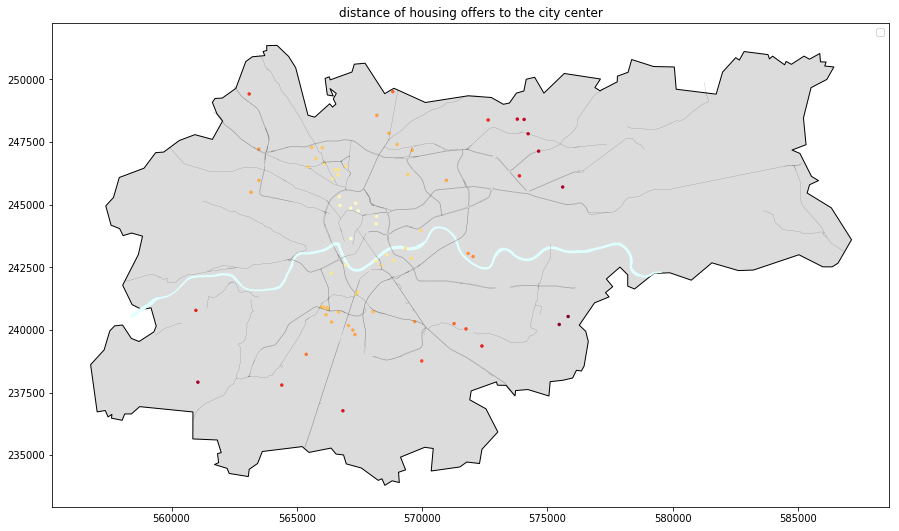

In [14]:
gdf['dst_center'] = gdf.apply(haversine, axis=1)
gdf.loc[gdf['dst_center'] < 15000]

ax = krk_border.plot(color='gainsboro', edgecolor='black')
ax.set_title("distance of housing offers to the city center")
ax.legend()
vistula.plot(ax=ax, color='lightcyan');
rds.plot(ax=ax, color='black', linewidth = 0.1);
gdf.plot(ax=ax, marker='o',column= 'dst_center', cmap='YlOrRd', markersize=6);